# Tweet sentiment analysis

In [17]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import boto3
import s3fs

## Get dataframe from S3 bucket

In [59]:
# # Read CSV file
# #tweets_today = pd.read_csv(r"..\datasets\raw_data\tweets{}.csv".format(datetime.date.today()))
# tweets_today = pd.read_csv(r"..\datasets\raw_data\tweets2019-10-08.csv")
# tweets_today = tweets_today.head(5000)
# # Gets tweet texts
# tweets_today_text = tweets_today["tweet"]
bucketname = 'ops-vw-interns-climate-perception-tweets'
dataframe = pd.DataFrame(columns=("creation date","keyword", "tweet", "username"))
s3 = boto3.resource("s3")

s3_tweets = s3.Bucket(bucketname).objects.all()
for file in s3_tweets:
    temp_df = pd.DataFrame(pd.read_json('s3://{}/{}'.format(bucketname, file.key)))
    dataframe = dataframe.append(temp_df, sort=False, ignore_index=True) 

dataframe_tweets = dataframe["tweet"]

## Data cleaning

In [61]:
# Preprocessing of tweet texts
def format_tweet(tweet):
    processed_tweet=""
    for word in tweet.split():
        # Removing URL from tweet
        processed_word = re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', word)
        # remove all single characters
        processed_word = re.sub('\s+[a-zA-Z]\s+', ' ', processed_word)
        # Remove single characters from the start
        processed_word = re.sub('\^[a-zA-Z]\s+', ' ', processed_word) 
        # Substituting multiple spaces with single space
        processed_word = re.sub('\s+', '', processed_word, flags=re.I)
        # Removing prefixed 'b'
        processed_word = re.sub('^b\s+', ' ', processed_word)
        # Removing &amp
        processed_word = re.sub('&amp', '&', processed_word)
        # Removing breaks
        processed_word = re.sub('<br/>', '', processed_word)
        # converts to lower
        processed_word = processed_word.lower()
        processed_tweet= processed_tweet+" "+processed_word
    return processed_tweet        
    
tweets_text = [format_tweet(tweet) for tweet in dataframe_tweets]
tweets_text = list(filter(None, tweets_text))

for tweet in tweets_text[:20]:
    print(tweet + "\n")


 im all for democracy and freedom of speech unless of course were talking about climate change protesters  those guys should be beaten up pepper sprayed locked up andor ran down by the cops because they inconvenience me 

 trees bans and new technology what arsenal chelsea and spurs are doing about climate change coyg afc 

 doug fords conservative government has made next to no progress on plan to cut carbon emissions but has spent millions on fighting a real plan to cut emissions onpoli cdnpoli climatechange elxn43 

 the saudi kings oil company chevron and russias mob run gazprom are the top three producers of greenhouse gases driving the entire worlds climate change trump republicans best people trumpgenocide climatestrike republicangenocide 

 global warming is a joke its just bad science its high jacking public policy its the greatest scam in history

 scifi ways scientists could mimic volcanic eruptions to help avert climate disaster 

 terrorism killer heatwaves deadly drought 

## Labeling tweets with NLTK vader

In [62]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ViMs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [63]:
sid = SentimentIntensityAnalyzer()

for tweet in tweets_text[5:10]:
    print("{0}: \n{1}\n\n".format(tweet, sid.polarity_scores(tweet)))

 scifi ways scientists could mimic volcanic eruptions to help avert climate disaster : 
{'neg': 0.331, 'neu': 0.514, 'pos': 0.154, 'compound': -0.4767}


 terrorism killer heatwaves deadly drought predicted for spain as climate change study reveals mediterranean is warming 20 faster than global average : 
{'neg': 0.312, 'neu': 0.632, 'pos': 0.056, 'compound': -0.8519}


 salem thanks for listening to my rant about the socioeconomic implications of climate change red wine does something weird to me hereforyou lyftreviews winewednesday: 
{'neg': 0.146, 'neu': 0.75, 'pos': 0.104, 'compound': -0.0516}


 we must no longer view the natural world as a mere warehouse of commodities for humans to exploit but rather a remarkable community to which we belong and to whom we owe responsibilities : 
{'neg': 0.077, 'neu': 0.741, 'pos': 0.182, 'compound': 0.705}


 is climate change doomsday coming : 
{'neg': 0.487, 'neu': 0.513, 'pos': 0.0, 'compound': -0.5859}




In [66]:
def get_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    if polarity == 0:
        return 'neutral'
    else:
        return 'negative'

polarity_tweets = [round(sid.polarity_scores(tweet)["compound"], 2)
                   for tweet in tweets_text]
sentiment_tweets = [get_sentiment(polarity) for polarity in polarity_tweets]
zipped_list = list(zip(sentiment_tweets, polarity_tweets,
                       dataframe['tweet'], dataframe['keyword'], dataframe['username'], dataframe['creation date']))

# Store to new dataframe
sentiment_df = pd.DataFrame(zipped_list, columns=[
    "Sentiment", "Polarity", "Tweet", "Keyword", "Username", "Creation Date"])
sentiment_df.tail(20)

,Sentiment,Polarity,Tweet,Keyword,Username,Creation Date
1597,negative,-0.38,Fight against Google https://t.co/GYqbtlwQxa,Climate change,💧National Times II,2019-10-13 19:38:16
1598,negative,-0.67,The lack of consensus on Global warming. Wake ...,Global warming,Edwin Thwaites,2019-10-13 19:38:13
1599,positive,0.30,Google has made some generous contributions to...,Climate change,Candace,2019-10-13 19:38:05
1600,negative,-0.57,I Ignored The Urgency Of Addressing Climate Ch...,Climate change,John Kenten,2019-10-13 19:38:00
1601,negative,-0.90,Stealing from taxpayers to give to a liar abou...,Global warming & Climate change,zahar,2019-10-13 19:37:59
1602,negative,-0.42,"Adam Bandt , If you reside in Canberra and you...",Climate change,tony sinclaire,2019-10-13 19:37:51
1603,neutral,0.00,Climate change is shaping Iowa's physical and ...,Climate change,John Kenten,2019-10-13 19:37:46
1604,negative,-0.66,"California governor blames greed, not climate ...",Climate change,Candace,2019-10-13 19:37:37
1605,negative,-0.27,Those scientists are liars !\nScientists endor...,Climate change,Aurelio Rocha,2019-10-13 19:37:36
1606,negative,-0.80,'They should be allowed to cry': Ecological di...,Climate change,Dr. Faisal Moola,2019-10-13 19:37:31


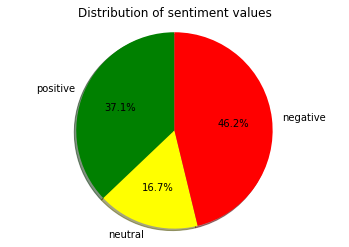

total positive: 600
total neutral: 270
total negative: 747


In [67]:
sentiment_count = round(sentiment_df["Polarity"].value_counts(), 2)

sentiments = [get_sentiment(polarity)
              for polarity in sentiment_df["Polarity"]]

sentiment_count_list = np.array([sentiments.count(
    "positive"), sentiments.count("neutral"), sentiments.count("negative")])

labels = ["positive", "neutral", "negative"]
colors = ["green", "yellow", "red"]
fig1, ax1 = plt.subplots()
ax1.pie(sentiment_count_list, labels=labels, shadow=True,
        autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')
plt.title("Distribution of sentiment values")
plt.show()
print("total positive: {}".format(sentiments.count('positive')))
print("total neutral: {}".format(sentiments.count('neutral')))
print("total negative: {}".format(sentiments.count('negative')))

Using this nltk vader implementation for sentiment analysis, we get entirely diferent results. There are way less neutral tweets and more than half of the tweets now have a negative sentiment assigned to them

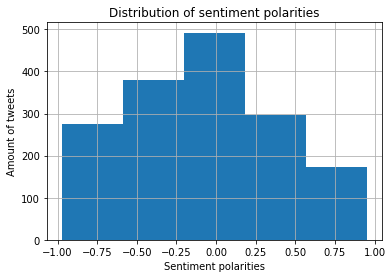

In [68]:
sentiment_df["Polarity"].hist(bins=5)
plt.title("Distribution of sentiment polarities")
plt.xlabel("Sentiment polarities")
plt.ylabel("Amount of tweets")
plt.show()

## Implementing machine learning algorithms

In [105]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.stem import PorterStemmer

### Divide into training and test sets

In [106]:
from sklearn.model_selection import train_test_split

# Extract features from df
features = sentiment_df["Tweet"]

# Extract labels from df
labels = sentiment_df["Sentiment"]


X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, test_size=0.2,
                                                    random_state=1)

print(len(X_train))
print(len(X_test))

1293
324


### Preparing pipeline variables

In [150]:
nltk.download('stopwords')
from nltk.corpus import stopwords

count_vec = CountVectorizer(strip_accents=None, lowercase=False, preprocessor = None)
tfidf = TfidfTransformer()
stopwords = stopwords.words("english")


def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ViMs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Implementing Multinomial Naive Bayes

In [143]:
from sklearn.naive_bayes import MultinomialNB

In [144]:
mnb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), ('clf', MultinomialNB())])

param_grid_mnb = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
                  #'vect__stop_words': [stopwords, None],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],
    
                  'clf__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'clf__fit_prior': [True, False]
                 }
grid_mnb = RandomizedSearchCV(mnb_pipeline, param_grid_mnb, n_iter=50, cv=9, verbose=1, n_jobs=-1, scoring='accuracy')
grid_mnb.fit(X_train, y_train)

Fitting 9 folds for each of 50 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.6min finished


RandomizedSearchCV(cv=9, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                          

In [145]:
print("Best parameters: ", grid_mnb.best_params_)

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x000002319BB79598>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__fit_prior': False, 'clf__alpha': 0.1}
Best cross-validation score: 64.66%


In [169]:
mnb = grid_mnb.best_estimator_
mnb.fit(X_train, y_train)
predictions_mnb = mnb.predict(X_test)
print(confusion_matrix(y_test, predictions_mnb))
print(classification_report(y_test, predictions_mnb))
print("The algorithm has reached an accuracy of: {:.2f}%".format(mnb.score(X_test, y_test)*100))

[[105   6  37]
 [ 19  29  13]
 [ 24   3  88]]
              precision    recall  f1-score   support

    negative       0.71      0.71      0.71       148
     neutral       0.76      0.48      0.59        61
    positive       0.64      0.77      0.70       115

    accuracy                           0.69       324
   macro avg       0.70      0.65      0.66       324
weighted avg       0.69      0.69      0.68       324

Best score: 68.52%


### Implementing Logistic regression

In [127]:
from sklearn.linear_model import LogisticRegression

In [130]:
import warnings
warnings.filterwarnings('ignore')

lr_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), ('clf', LogisticRegression(random_state=1))])

param_grid_lr ={
                'vect__ngram_range': [(1,1),(1,2)],
                #'vect__stop_words': [stopwords, None],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],
    
                'clf__dual': [True, False],
                'clf__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ],
                'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'clf__fit_intercept': [True, False],
                'clf__max_iter' : [100, 110, 120, 130, 140],
                'clf__warm_start': [True, False]
              }
grid_lr = RandomizedSearchCV(lr_pipeline, param_grid_lr, n_iter=500,  verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 10.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=False,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                         

In [131]:
print("Best parameters: ", grid_lr.best_params_)

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x00000231A772E9D8>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l1', 'clf__warm_start': True, 'clf__tol': 1e-06, 'clf__max_iter': 110, 'clf__fit_intercept': True, 'clf__dual': False, 'clf__C': 1000}
Best cross-validation score: 65.82%


In [159]:
lr = grid_lr.best_estimator_

lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)

print(confusion_matrix(y_test, predictions_lr))
print(classification_report(y_test, predictions_lr))
print("The algorithm has reached an accuracy of: {:.2f}%".format(lr.score(X_test, y_test) *100))

Best score: 65.12%
[[100   9  39]
 [ 15  36  10]
 [ 32   8  75]]
              precision    recall  f1-score   support

    negative       0.68      0.68      0.68       148
     neutral       0.68      0.59      0.63        61
    positive       0.60      0.65      0.63       115

    accuracy                           0.65       324
   macro avg       0.65      0.64      0.65       324
weighted avg       0.65      0.65      0.65       324



### Implementing Support Vector Machine

In [152]:
from sklearn.svm import SVC

In [173]:
svc_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), ('clf', SVC(random_state=1))])

param_grid_svm = {
                  'vect__ngram_range': [(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
                  'vect__stop_words': [stopwords, None],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__C': [0.1, 1, 10, 100],
                  'clf__kernel': ['linear', 'rbf', 'poly'],
                  'clf__gamma': [0.1, 1, 10, 100],
                  'clf__degree': [0, 1, 2, 3, 4, 5, 6]
                 }

grid_svc = RandomizedSearchCV(svc_pipeline, param_grid_svm, n_iter=80, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=False,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                         

In [174]:
print("Best parameters: ", grid_svc.best_params_)

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x00000231A152F840>, 'vect__stop_words': None, 'vect__ngram_range': (1, 2), 'tfidf__use_idf': False, 'tfidf__norm': 'l1', 'clf__kernel': 'linear', 'clf__gamma': 10, 'clf__degree': 0, 'clf__C': 100}


In [175]:
svm = grid_svc.best_estimator_
svm_fit = svm.fit(X_train, y_train)
score_svm = svm.score(X_test, y_test)
predictions_svm = svm.predict(X_test)
print(confusion_matrix(y_test, predictions_svm))
print(classification_report(y_test, predictions_svm))
print("The algorithm has reached an accuracy of: {:.2f}%".format(score_svm*100))

[[93 14 41]
 [12 45  4]
 [33 10 72]]
              precision    recall  f1-score   support

    negative       0.67      0.63      0.65       148
     neutral       0.65      0.74      0.69        61
    positive       0.62      0.63      0.62       115

    accuracy                           0.65       324
   macro avg       0.65      0.66      0.65       324
weighted avg       0.65      0.65      0.65       324

The algorithm has reached an accuracy of: 64.81%


### Implementing Random Forest

In [134]:
from sklearn.ensemble import RandomForestClassifier

In [166]:
rf_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), ('clf', RandomForestClassifier(random_state=1))])

param_grid_rf = {
                 'vect__ngram_range': [(1,2)],
                 'vect__tokenizer': [tokenizer, tokenizer_porter],
                 'vect__stop_words': [stopwords, None],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],                  
    
                 'clf__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
                 'clf__max_features': ['auto', 'sqrt'],
                 'clf__max_depth': np.linspace(1, 32, 32, endpoint=True),
                 'clf__min_samples_split': [2, 5, 10],
                 'clf__min_samples_leaf': [1, 2, 4],
                 'clf__bootstrap': [True, False]
                }

grid_rf = RandomizedSearchCV(rf_pipeline, param_grid_rf, cv=5, n_iter=500 , verbose=1, n_jobs=-1, scoring='accuracy')

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 11.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=False,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                         

In [167]:
print("Best parameters: ", grid_rf.best_params_)

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x00000231A152F840>, 'vect__stop_words': None, 'vect__ngram_range': (1, 2), 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'auto', 'clf__max_depth': 32.0, 'clf__bootstrap': False}


In [168]:
rf = grid_rf.best_estimator_

rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)

print(confusion_matrix(y_test, predictions_rf))
print(classification_report(y_test, predictions_rf))
print("The algorithm has reached an accuracy of: {:.2f}%".format(rf.score(X_test, y_test) *100))

Best score: 60.49%
[[125   7  16]
 [ 39  20   2]
 [ 58   6  51]]
              precision    recall  f1-score   support

    negative       0.56      0.84      0.68       148
     neutral       0.61      0.33      0.43        61
    positive       0.74      0.44      0.55       115

    accuracy                           0.60       324
   macro avg       0.64      0.54      0.55       324
weighted avg       0.63      0.60      0.59       324

